# Linear Regression
### Parameters:
System:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
    * **speed** (*land speed*)
        * **other speeds**: fly, climb, swim
    * **num immunities**
    * **resistances**: fire, cold, electricity, acid, piercing, slashing, physical, bludgeoning, mental, poison, all-damage
    * **weaknesses**: cold-iron, good, fire, cold, area-damage, splash-damage, evil, slashing
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

Items
* **items**
    * **melee**
    * **ranged**
    * **spells nr**

### Prediction: *level*
## Loading data

In [72]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
    "land_speed",
    "num_immunities",
    "fly",
    "swim",
    "climb",
    "fire_resistance",
    "cold_resistance",
    "electricity_resistance",
    "acid_resistance",
    "piercing_resistance",
    "slashing_resistance",
    "physical_resistance",
    "bludgeoning_resistance",
    "mental_resistance",
    "poison_resistance",
    "all-damage_resistance",
    "cold-iron_weakness",
    "good_weakness",
    "fire_weakness",
    "cold_weakness",
    "area-damage_weakness",
    "splash-damage_weakness",
    "evil_weakness",
    "slashing_weakness",
    "melee",
    "ranged",
    "spells",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [73]:
df.head()

,num_immunities,will,cha,int,hp,wis,con,str,focus,book,...,spells_nr_lvl_4,spells_nr_lvl_5,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg
0,3,17,1,1,215,2,5,7,1,Pathfinder Bestiary,...,0,0,0,0,0,0,23,22.0,0,0.0
1,0,16,1,-4,220,2,5,9,0,Pathfinder Bestiary,...,0,0,0,0,0,0,23,22.0,0,0.0
2,0,15,-2,-4,175,3,6,7,0,Pathfinder Bestiary,...,0,0,0,0,0,0,21,16.0,0,0.0
3,3,32,6,6,315,5,5,7,1,Pathfinder Bestiary,...,1,0,1,0,0,0,33,31.5,0,0.0
4,0,4,1,-1,20,1,1,-5,1,Pathfinder Bestiary,...,1,0,0,0,0,0,0,0.0,8,5.0


## Preprocessing and train test split

In [74]:
from sklearn.preprocessing import MinMaxScaler


columns = [col for col in df.columns if col not in ["book", "level"]]
scaler = MinMaxScaler()
min_max_df = pd.DataFrame()
min_max_df[columns] = pd.DataFrame(scaler.fit_transform(df[columns]))
min_max_df["book"] = df["book"]
min_max_df["level"] = df["level"]

In [75]:
min_max_df.head()

,num_immunities,will,cha,int,hp,wis,con,str,focus,fortitude,...,spells_nr_lvl_6,spells_nr_lvl_7,spells_nr_lvl_8,spells_nr_lvl_9,melee_max_bonus,avg_melee_dmg,ranged_max_bonus,avg_ranged_dmg,book,level
0,0.1875,0.395349,0.3750,0.400000,0.386447,0.333333,0.416667,0.705882,0.333333,0.500000,...,0.0,0.0,0.0,0.0,0.489362,0.385965,0.000000,0.000000,Pathfinder Bestiary,10
1,0.0000,0.372093,0.3750,0.066667,0.395604,0.333333,0.416667,0.823529,0.000000,0.477273,...,0.0,0.0,0.0,0.0,0.489362,0.385965,0.000000,0.000000,Pathfinder Bestiary,10
2,0.0000,0.348837,0.1875,0.066667,0.313187,0.416667,0.500000,0.705882,0.000000,0.454545,...,0.0,0.0,0.0,0.0,0.446809,0.280702,0.000000,0.000000,Pathfinder Bestiary,8
3,0.1875,0.744186,0.6875,0.733333,0.569597,0.583333,0.416667,0.705882,0.333333,0.681818,...,0.2,0.0,0.0,0.0,0.702128,0.552632,0.000000,0.000000,Pathfinder Bestiary,17
4,0.0000,0.093023,0.3750,0.266667,0.029304,0.250000,0.083333,0.000000,0.333333,0.136364,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.186047,0.081967,Pathfinder Bestiary,1


### Chronological split

In [76]:
from training.splitting_dataset import split_dataframe

os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(min_max_df, test_size=0.31)
os.chdir("../notebooks/models/linear_regression")

In [77]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

In [78]:
y_train = y_train.astype("int64")
y_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 841 entries, 0 to 840
Series name: level
Non-Null Count  Dtype
--------------  -----
841 non-null    int64
dtypes: int64(1)
memory usage: 13.1 KB


### Random split

In [79]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(min_max_df, chronological_split=False, test_size=0.25)

In [80]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Linear Regression
### With chronological split

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


model = LinearRegression()
model.fit(X_train, y_train)
predict_train = model.predict(X_train)
predict = model.predict(X_test)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

r2 = r2_score(y_train, y_pred_train)
print(f"R2 score:{r2:.2f}")

R2 score:0.99


In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse:.2f}")
print(f"MAE test: {mae:.2f}")

RMSE train: 0.43
RMSE test: 87067693319.53
MAE test: 10602836238.00


In [83]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "full", rmse, mae]

###### MAE by level

In [84]:
from training.results import plot_mae_by_level

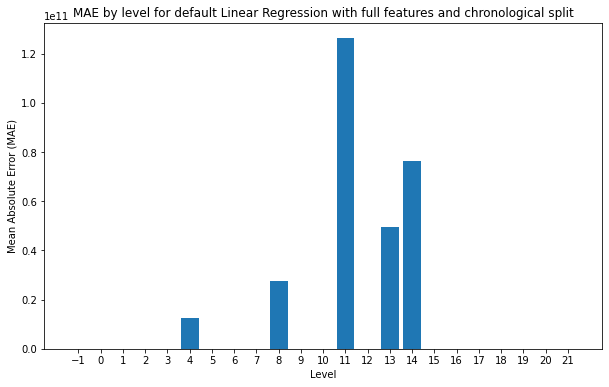

In [85]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default Linear Regression with full features and chronological split",
)

In [86]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Default:
RMSE: 87067693319.53



TypeError: '>' not supported between instances of 'str' and 'int'

In [ ]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for default Linear Regression with full features, threshold = 0.5 and chronological split",
)

In [ ]:
plot_confusion_matrix(
    0.33,
    predict,
    y_test,
    title="Confusion matrix for default Linear Regression with full features, threshold = 0.33 and chronological split",
)

### With random split

In [ ]:
model = LinearRegression()
model.fit(X_train_random_split, y_train_random_split)

y_pred_train_random_split = model.predict(X_train_random_split)
y_pred_test_random_split = model.predict(X_test_random_split)

r2 = r2_score(y_train_random_split, y_pred_train_random_split)
print(f"R2 score:{r2:.2f}")

In [ ]:
rmse_train = mean_squared_error(
    y_train_random_split, y_pred_train_random_split, squared=False
)
rmse = mean_squared_error(y_test_random_split, y_pred_test_random_split, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test_random_split)

print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse:.2f}")
print(f"MAE test: {mae:.2f}")

In [ ]:
results.loc[1] = ["random", "default", "full", rmse, mae]

###### MAE by level

In [ ]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test_random_split,
    title="MAE by level for default Linear Regression with full features and random split",
)

In [ ]:
check_round_predictions(
    ["round", 0.33, 0.45], y_test_random_split, y_pred_test_random_split
)

In [ ]:
plot_confusion_matrix(
    "round",
    y_pred_test_random_split,
    y_test_random_split,
    title="Confusion matrix for default Linear Regression with full features, threshold = 0.5 and random split",
)

In [ ]:
plot_confusion_matrix(
    0.33,
    y_pred_test_random_split,
    y_test_random_split,
    title="Confusion matrix for default Linear Regression with full features, threshold = 0.33 and random split",
)

## Tuning (ridge, LASSO)

### With chronological split

In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV
from training.results import assess_regression_model


reg_ridge_cv = RidgeCV(alphas=np.linspace(0.1, 100, 1000))
reg_lasso_cv = LassoCV(n_alphas=1000, random_state=0)

reg_ridge_cv = reg_ridge_cv.fit(X_train, y_train)
reg_lasso_cv = reg_lasso_cv.fit(
    X_train,
    np.array(y_train).reshape(
        y_train.size,
    ),
)

reg_linear = LinearRegression()
reg_linear.fit(X_train, y_train)

print(f"Ridge CV alpha: {reg_ridge_cv.alpha_:.4f}")
print(f"Lasso CV alpha: {reg_lasso_cv.alpha_:.4f}")
print()

print("Linear Regression")
assess_regression_model(reg_linear, X_train, X_test, y_train, y_test, r2=True)

print("Ridge:")
rmse, mae = assess_regression_model(
    reg_ridge_cv, X_train, X_test, y_train, y_test, r2=True
)
results.loc[2] = ["chronological", "Ridge", "full", rmse, mae]

print("Lasso:")
rmse, mae = assess_regression_model(
    reg_lasso_cv, X_train, X_test, y_train, y_test, r2=True
)
results.loc[3] = ["chronological", "Lasso", "full", rmse, mae]

###### MAE by level Ridge

In [ ]:
y_pred_test = reg_ridge_cv.predict(X_test)

In [ ]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for Linear Regression with full features, Ridge tunning and chronological split",
)

###### MAE by level LASSO

In [ ]:
y_pred_test = reg_lasso_cv.predict(X_test)

In [ ]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for Linear Regression with full features, LASSO tunning and chronological split",
)

In [ ]:
feature_names = X_train.columns

ridgecv_coefficients = pd.DataFrame(
    {
        "feature name": columns,
        "coefficients": reg_ridge_cv.coef_,
    }
)
best_features = ridgecv_coefficients.sort_values("coefficients", ascending=False)
best_features.plot.barh(
    x="feature name", y="coefficients", title="Best features", figsize=(6.4, 8.5)
)

In [ ]:
sorted(feature_names[reg_lasso_cv.coef_ == 0])

### With random split

In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV

reg_ridge_cv = RidgeCV(alphas=np.linspace(1e-3, 1, 10000))
reg_lasso_cv = LassoCV(alphas=np.linspace(1e-4, 1e-1, 1000), random_state=0)

reg_ridge_cv = reg_ridge_cv.fit(X_train_random_split, y_train_random_split)
reg_lasso_cv = reg_lasso_cv.fit(
    X_train_random_split,
    np.array(y_train_random_split).reshape(
        y_train_random_split.size,
    ),
)

print(f"Ridge CV alphas: {reg_ridge_cv.alpha_:.4f}")
print(f"Lasso CV alpha: {reg_lasso_cv.alpha_:.4f}")
print()
print("Ridge:")
rmse, mae = assess_regression_model(
    reg_ridge_cv,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
    r2=True,
)
results.loc[4] = ["random", "Ridge", "full", rmse, mae]

print("Lasso:")
rmse, mae = assess_regression_model(
    reg_lasso_cv,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
    r2=True,
)
results.loc[5] = ["random", "Lasso", "full", rmse, mae]

###### MAE by level Ridge

In [ ]:
y_pred_test_random_split = reg_ridge_cv.predict(X_test_random_split)

In [ ]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test_random_split,
    title="MAE by level for Linear Regression with full features, Ridge tunning and random split",
)

###### MAE by level LASSO

In [ ]:
y_pred_test_random_split = reg_lasso_cv.predict(X_test_random_split)

In [ ]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test_random_split,
    title="MAE by level for Linear Regression with full features, LASSO tunning and random split",
)

In [ ]:
feature_names = X_train.columns

ridgecv_coefficients = pd.DataFrame(
    {
        "feature name": columns,
        "coefficients": reg_ridge_cv.coef_,
    }
)
best_features = ridgecv_coefficients.sort_values("coefficients", ascending=False)
best_features.plot.barh(
    x="feature name", y="coefficients", title="Best features", figsize=(6.4, 8.5)
)

In [ ]:
eliminated_features = sorted(feature_names[reg_lasso_cv.coef_ == 0])
print(eliminated_features)

## Summary

In [ ]:
results

In [ ]:
from training.results import plot_summary

In [ ]:
plot_summary(results, "RMSE", title="RMSE for Linear Regression with full features")

In [ ]:
plot_summary(results, "MAE", title="RMSE for Linear Regression with full features")

In [ ]:
results.to_json("./linear_regression_full_results.json", indent=2)